In [134]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from sklearn.model_selection import cross_val_score
from sklearn import (
    metrics, 
    linear_model, 
    ensemble,
    neighbors,
)

In [135]:
df = pd.read_csv('../../data/titanic_train.csv')

In [136]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
features = ['Pclass', 'Fare', 'Parch', 'SibSp']
target = 'Survived'

X = df[features]
y = df[target]

In [138]:
def evaluate_models(X, y):
    
    cls = ensemble.RandomForestClassifier(n_estimators=50) 
    cls.fit(X, y)

    print 'Random Forest:', cross_val_score(cls, X, y, scoring='roc_auc', cv=5).mean()
    
    cls = linear_model.LogisticRegression() 
    cls.fit(X, y)

    print 'Logistic Regression:', cross_val_score(cls, X, y, scoring='roc_auc', cv=5).mean()
    
    cls = ensemble.GradientBoostingClassifier(n_estimators=50) 
    cls.fit(X, y)

    print 'GBDT:', cross_val_score(cls, X, y, scoring='roc_auc', cv=5).mean()
    
    cls = neighbors.KNeighborsClassifier(n_neighbors=5)
    cls.fit(X, y)

    print 'KNN:', cross_val_score(cls, X, y, scoring='roc_auc', cv=5).mean()

In [139]:
evaluate_models(X, y)

Random Forest: 0.725079019387
Logistic Regression: 0.706209190026
GBDT: 0.75532487822
KNN: 0.698138660947


In [140]:
df['Sex_value'] = df['Sex'].map(lambda x: 0 if x == 'male' else 1)

In [141]:
# Equivalent to the line above
def convert_to_value(x):
    if x == 'male':
        return 0
    else:
        return 1

In [142]:
features = ['Pclass', 'Fare', 'Parch', 'SibSp', 'Sex_value']
target = 'Survived'

X = df[features]
y = df[target]

evaluate_models(X, y)

Random Forest: 0.842191564155
Logistic Regression: 0.831267335596
GBDT: 0.856451547076
KNN: 0.788960600159


In [143]:
df['Age'].isnull().sum()

177

In [144]:
df['Age_fixed'] = df['Age'].fillna(value=df['Age'].median())

In [145]:
features = ['Pclass', 'Fare', 'Parch', 'SibSp', 'Sex_value', 'Age_fixed']
target = 'Survived'

X = df[features]
y = df[target]

evaluate_models(X, y)

Random Forest: 0.855534046559
Logistic Regression: 0.848148698795
GBDT: 0.860686359832
KNN: 0.720424599002


In [146]:
df['Age_fixed_normal'] = df['Age_fixed'].map(lambda x: (x - df['Age_fixed'].mean()) / df['Age_fixed'].std())

In [147]:
features = ['Pclass', 'Fare', 'Parch', 'SibSp', 'Sex_value', 'Age_fixed_normal']
target = 'Survived'

X = df[features]
y = df[target]

evaluate_models(X, y)

Random Forest: 0.861980508053
Logistic Regression: 0.847280566286
GBDT: 0.860686359832
KNN: 0.787972191234


In [148]:
df['Embarked_fixed'] = df['Embarked'].dropna()

In [149]:
df = pd.get_dummies(df, prefix='Embk', columns=['Embarked_fixed'], drop_first=True)

In [150]:
features = ['Pclass', 'Fare', 'Parch', 'SibSp', 'Sex_value', 'Age_fixed_normal', 'Embk_Q', 'Embk_S']
target = 'Survived'

X = df[features]
y = df[target]

evaluate_models(X, y)

Random Forest: 0.853137882379
Logistic Regression: 0.848663549548
GBDT: 0.86828750088
KNN: 0.784630341639


In [151]:
df.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [152]:
df['Name'].sample(10)

696                            Kelly, Mr. James
412                      Minahan, Miss. Daisy E
646                           Cor, Mr. Liudevit
12               Saundercock, Mr. William Henry
81                  Sheerlinck, Mr. Jan Baptist
43     Laroche, Miss. Simonne Marie Anne Andree
784                            Ali, Mr. William
510                    Daly, Mr. Eugene Patrick
211                  Cameron, Miss. Clear Annie
171                        Rice, Master. Arthur
Name: Name, dtype: object

In [153]:
df['Title'] = df['Name'].map(lambda x: re.search(r'\s[A-Z][a-z]+\.', x).group())

In [154]:
df['Title'] = df['Title'].map(lambda x: {' Ms.': ' Miss.'}.get(x, x))

In [155]:
df = pd.get_dummies(df, prefix='Title', columns=['Title'], drop_first=True)

In [157]:
titles = [x for x in df.columns if re.search(r'Title\_', x)]

features = ['Pclass', 'Fare', 'Parch', 'SibSp', 'Sex_value', 'Age_fixed_normal', 'Embk_Q', 'Embk_S'] + titles
target = 'Survived'

X = df[features]
y = df[target]

evaluate_models(X, y)

Random Forest: 0.854486944577
Logistic Regression: 0.867586014063
GBDT: 0.866467811696
KNN: 0.804640798989


In [160]:
df['Has_cabin'] = df['Cabin'].map(lambda x: 0 if pd.isnull(x) else 1)

In [173]:
titles = [x for x in df.columns if re.search(r'Title\_', x)]

features = ['Pclass', 'Fare', 'Parch', 'SibSp', 'Sex_value', 'Age_fixed', 'Embk_Q', 'Embk_S', 'Has_cabin'] + titles
target = 'Survived'

X = df[features]
y = df[target]

evaluate_models(X, y)

Random Forest: 0.863176636612
Logistic Regression: 0.86939726342
GBDT: 0.870879610175
KNN: 0.743359907766


In [174]:
from sklearn import tree

cls = tree.DecisionTreeClassifier(max_depth=4)
cls.fit(X, y)

tree.export_graphviz(cls, out_file='tree.dot')

In [169]:
features[4]

'Sex_value'

In [175]:
import os
os.system('dot -Tpng tree.dot -o tree.png')

0

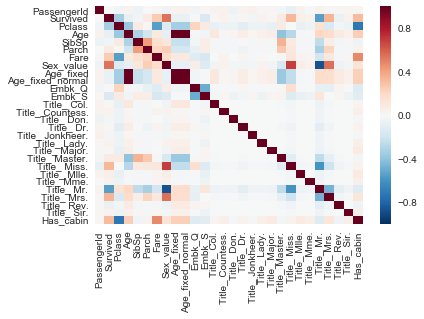

In [178]:
sns.heatmap(df.corr())

In [180]:
test = pd.read_csv('../../data/titanic_test.csv')

In [181]:
def do_feature_engineering(data):
    ....
    return data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S
